In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 49.9 MB/s eta 0:00:00


In [ ]:
!pip -q install gtts
!pip install telebot
!pip install pyTelegramBotAPI
!pip install telegram_menu

In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
import telebot
from telebot import types
import random
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [ ]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving korpas.json to korpas (1).json


In [ ]:
# Importing the dataset
with open('korpas.json') as content:
  data1 = json.load(content)

In [ ]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  print(intent)
  responses[intent['tag']] = intent.get('responses')
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
  for pattern in intent['patterns']:
     w = nltk.word_tokenize(pattern)
     words.extend(w)
     documents.append((w, intent['tag']))
     # add to our classes list
     if intent['tag'] not in classes:
       classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

{'tag': 'greeting1', 'patterns': ['hallo', 'hai', 'halo', 'hei', 'hi', 'hy', 'pagi', 'morning', 'siang', 'afternoon', 'sore', 'malam', 'bro', 'sis', 'kawan'], 'responses': ['Hai! KriptoAyoMaju di sini. Mau tau informasi tentang apa nih?', 'Halo! Saya KriptoAyoMaju, salam kenal ya! Mau tau tentang kripto, kan?', 'Helo! Ini KriptoAyoMaju. Lagi kepo tentang kripto ya?']}
{'tag': 'kripto1', 'patterns': ['Apa itu kripto?', 'Apa yang dimaksud dengan mata uang kripto?', 'Apa cryptocurrency itu?'], 'responses': ['Mata uang kripto adalah aset digital yang dirancang untuk bekerja sebagai media pertukaran yang menggunakan kriptografi yang kuat untuk mengamankan transaksi keuangan, mengontrol proses pembuatan unit tambahan, dan memverifikasi transfer aset', 'Aset digital menggunakan teknologi kriptografi']}
{'tag': 'pencipta_kripto1', 'patterns': ['Siapa pembuat kripto?', 'Siapa pencipta kripto?', 'Siapa pendiri kripto?'], 'responses': ['Satoshi Nakamoto adalah nama samaran individu anonim yang di

In [ ]:
print(len(responses))
print(len(inputs))
print(len(tags))
i=1
for key,value in responses.items():
  print(i, "tag:", key,"response:",value)
  i+=1

153
319
319
1 tag: greeting1 response: ['Hai! KriptoAyoMaju di sini. Mau tau informasi tentang apa nih?', 'Halo! Saya KriptoAyoMaju, salam kenal ya! Mau tau tentang kripto, kan?', 'Helo! Ini KriptoAyoMaju. Lagi kepo tentang kripto ya?']
2 tag: kripto1 response: ['Mata uang kripto adalah aset digital yang dirancang untuk bekerja sebagai media pertukaran yang menggunakan kriptografi yang kuat untuk mengamankan transaksi keuangan, mengontrol proses pembuatan unit tambahan, dan memverifikasi transfer aset', 'Aset digital menggunakan teknologi kriptografi']
3 tag: pencipta_kripto1 response: ['Satoshi Nakamoto adalah nama samaran individu anonim yang disebut sebagai pendiri BTC yang merupakan mata uang kripto pertama. ']
4 tag: goodbye1 response: ['Bye!', 'Dadahh!', 'Good bye!']
5 tag: terimakasih1 response: ['Dengan senang hati :)', 'Sama-sama yaa']
6 tag: pengertian_blockchain1 response: ['Blockchain adalah database terdistribusi yang menyimpan daftar catatan pesanan yang terus bertambah, 

In [ ]:
# Cetak data keseluruhan
data

,patterns,tags
0,hallo,greeting1
1,hai,greeting1
2,halo,greeting1
3,hei,greeting1
4,hi,greeting1
...,...,...
314,Mohon berikan panduan withdraw dari exchanger ...,exchanger_kripto7
315,Berapa lama waktu yang dibutuhkan untuk deposi...,exchanger_kripto8
316,Berapa biaya transaksi yang dikenakan oleh exc...,exchanger_kripto9
317,Apakah exchanger kripto mendukung mata uang tr...,exchanger_kripto10


In [ ]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,hallo,greeting1
1,hai,greeting1
2,halo,greeting1
3,hei,greeting1
4,hi,greeting1


In [ ]:
data.tail()

,patterns,tags
314,Mohon berikan panduan withdraw dari exchanger ...,exchanger_kripto7
315,Berapa lama waktu yang dibutuhkan untuk deposi...,exchanger_kripto8
316,Berapa biaya transaksi yang dikenakan oleh exc...,exchanger_kripto9
317,Apakah exchanger kripto mendukung mata uang tr...,exchanger_kripto10
318,Apakah exchanger kripto menyediakan wallet unt...,exchanger_kripto11


In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

331 unique lemmatized words ['(', ')', '.', '1', '3', '6', 'ada', 'adalah', 'afternoon', 'akan', 'akun', 'all-time', 'aman', 'amerika', 'analisa', 'analisis', 'anonim', 'antara', 'apa', 'apakah', 'aset', 'ath', 'average', 'bagaimana', 'bai', 'baik', 'balik', 'band', 'bank', 'banyak', 'bata', 'batasan', 'bear', 'bearish', 'bekerja', 'beli', 'berapa', 'berbeda', 'berdampak', 'berfungsi', 'berhubungan', 'berikan', 'berjalan', 'berlaku', 'berpartisipasi', 'bersertifikat', 'biaya', 'binance', 'bisa', 'bitcoin', 'blockchain', 'bnb', 'bollinger', 'bottom', 'breakout', 'bro', 'buatan', 'bulan', 'bull', 'bullish', 'bye', 'byee', 'candlestick', 'cara', 'cardano', 'cash', 'chainlink', 'classic', 'coin', 'contoh', 'contract', 'convergence', 'crypto', 'cryptocurrency', 'dadah', 'dah', 'dalam', 'dan', 'dana', 'dapat', 'dari', 'decentralized', 'defi', 'dekat', 'dengan', 'depan', 'deposit', 'di', 'dibutuhkan', 'diciptakan', 'digital', 'digunakan', 'diinvestasikan', 'diizinkan', 'dikenakan', 'dikonvers

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

153 classes ['BNB2', 'BNB3', 'CaraKerjaBinanceCoin', 'CaraKerjaBitcoin', 'CaraKerjaDeFi', 'CaraKerjaEthereum', 'CaraKerjaMetaverseCoin', 'DEFI1', 'DEFI2', 'DEFI3', 'DEFI4', 'Etherium2', 'Etherium3', 'MetaverseCoin1', 'MetaverseCoin2', 'RegulasiBinanceCoindiAmerikaSerikat', 'RegulasiBinanceCoindiIndonesia', 'RegulasiBinanceCoindiInggris', 'RegulasiBinanceCoindiJerman', 'RegulasiBitcoindiAmerikaSerikat', 'RegulasiBitcoindiIndonesia', 'RegulasiBitcoindiInggris', 'RegulasiBitcoindiJerman', 'RegulasiDeFidiAmerikaSerikat', 'RegulasiDeFidiIndonesia', 'RegulasiDeFidiInggris', 'RegulasiDeFidiJerman', 'RegulasiEthereumdiAmerikaSerikat', 'RegulasiEthereumdiIndonesia', 'RegulasiEthereumdiInggris', 'RegulasiEthereumdiJerman', 'RegulasiMetaverseCoindiAmerikaSerikat', 'RegulasiMetaverseCoindiIndonesia', 'RegulasiMetaverseCoindiInggris', 'RegulasiMetaverseCoindiJerman', 'ai_kripto1', 'aman_kripto1', 'analisis_fundamental1', 'analisis_kripto1', 'analisis_teknikal1', 'anonim_kripto1', 'bagaimana_kripto1

In [ ]:
# documents = combination between patterns and intents
print (len(documents), "documents")

319 documents


In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[172],
 [173],
 [174],
 [175],
 [176],
 [177],
 [178],
 [179],
 [180],
 [181],
 [182],
 [183],
 [184],
 [185],
 [186],
 [4, 14, 1],
 [4, 11, 36, 15, 6, 5, 1],
 [4, 81, 14],
 [82, 187, 1],
 [82, 188, 1],
 [82, 189, 1],
 [190],
 [191],
 [109],
 [192],
 [193, 109],
 [194, 195],
 [196, 197],
 [198],
 [199, 110],
 [200],
 [201, 110],
 [111, 112],
 [202],
 [111, 112, 203],
 [4, 14, 49],
 [4, 11, 36, 15, 49],
 [2, 10, 39, 49],
 [2, 49, 70],
 [4, 14, 71],
 [4, 11, 36, 15, 71],
 [2, 10, 39, 71],
 [2, 71, 70],
 [2, 10, 39, 6, 5, 1],
 [2, 1, 70],
 [2, 81, 70],
 [55, 204, 205, 6, 5, 1],
 [83, 1],
 [55, 84, 81],
 [113, 114],
 [113, 85],
 [55, 31, 6, 5, 1],
 [55, 31, 1],
 [55, 31, 206, 1],
 [207],
 [13],
 [208, 1],
 [3, 1, 209, 23],
 [3, 17, 23, 7, 24],
 [3, 17, 115],
 [1, 115],
 [3, 17, 116],
 [1, 116],
 [4, 210, 1],
 [4, 46, 56, 6, 5, 1],
 [117, 1],
 [56, 1],
 [4, 46, 211, 1],
 [86, 1],
 [86, 17],
 [212, 1],
 [213, 1],
 [4, 11, 36, 15, 57],
 [4, 14, 57],
 [57, 1],
 [2, 10, 72, 57, 1],
 [10, 57, 1

In [ ]:
# Apply padding
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 172]
 [  0   0   0 ...   0   0 173]
 [  0   0   0 ...   0   0 174]
 ...
 [  0   0   0 ... 148  32   1]
 [  0   0   0 ...   6   5  50]
 [  0   0   0 ...  37  84   1]]


In [ ]:
# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[ 64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  77  77  77
  99  99  99  63  63  63  63  63  63  63  63  63 149 149 149 149 149 100
 100  73  73 101 101  75  75  74  74  74 102 102 102 102  83  83  83  83
  83  83  83  66  66  65  65  65  65  65  70  70  70  72  72  72  71  71
 152 152 152  48  48  38  38  87  69  69  37  37  39  39  51  51  51  51
  50  50  47  47  47  47  47  47  44  44  44  44  44  44  41  41  76  76
  45  45  36  36  46  46  84  84 103 103  86  86  40  40 121 121  49  49
 151 151  42  42  67  67  68  68 150 150  85  85  35  35  43  43  62  62
  78  78  79  79  80  80  81  81  82  82   7   7   8   8   9   9  10  10
  13  13  14  14  11  11  12  12   0   0   1   1  20  20  20  28  28  28
  16  16  16  24  24  24  32  32  32  19  19  19  27  27  27  15  15  15
  23  23  23  31  31  31  21  21  21  21  29  29  29  17  17  17  25  25
  25  33  33  33  22  22  22  30  30  30  18  18  18  26  26  26  34  34
  34   3   3   3   5   5   5   2   2   2   4   4   

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

15


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  328
output length:  153


In [ ]:
pickle.dump(words, open('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/words.pkl','wb'))
pickle.dump(classes, open('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/classes.pkl','wb'))

FileNotFoundError: ignored

In [ ]:
pickle.dump(le, open('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/le.pkl','wb'))
pickle.dump(tokenizer, open('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/tokenizers.pkl','wb'))

FileNotFoundError: ignored

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
# Menampilkan Parameter Model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 15, 10)            3290      
                                                                 
 lstm_1 (LSTM)               (None, 15, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 153)               23103     
                                                                 
Total params: 27233 (106.38 KB)
Trainable params: 27233 (106.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=2000)

Epoch 1/2000
10/10 [==============================] - 3s 5ms/step - loss: 5.0305 - accuracy: 0.0000e+00
Epoch 2/2000
10/10 [==============================] - 0s 5ms/step - loss: 5.0192 - accuracy: 0.0376
Epoch 3/2000
10/10 [==============================] - 0s 5ms/step - loss: 5.0013 - accuracy: 0.0470
Epoch 4/2000
10/10 [==============================] - 0s 5ms/step - loss: 4.9708 - accuracy: 0.0470
Epoch 5/2000
10/10 [==============================] - 0s 10ms/step - loss: 4.8988 - accuracy: 0.0470
Epoch 6/2000
10/10 [==============================] - 0s 9ms/step - loss: 4.8067 - accuracy: 0.0470
Epoch 7/2000
10/10 [==============================] - 0s 8ms/step - loss: 4.7480 - accuracy: 0.0470
Epoch 8/2000
10/10 [==============================] - 0s 8ms/step - loss: 4.7042 - accuracy: 0.0470
Epoch 9/2000
10/10 [==============================] - 0s 7ms/step - loss: 4.6549 - accuracy: 0.0502
Epoch 10/2000
10/10 [==============================] - 0s 6ms/step - loss: 4.6112 - accuracy: 0

In [ ]:
model.save('lstm_chatbottol.h5')

In [ ]:
from google.colab import files
files.download('lstm_chatbottol.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

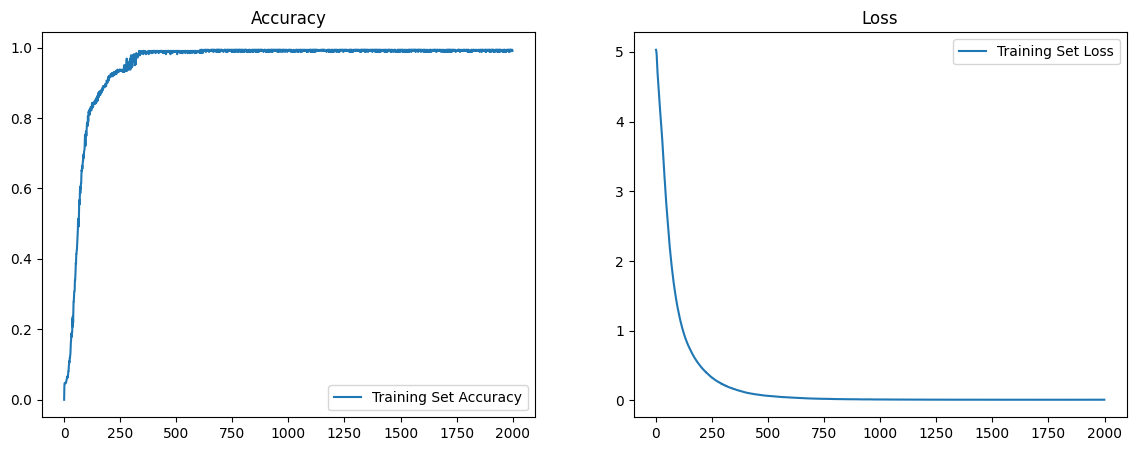

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
from sqlalchemy import Null
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  sekuense =tokenizer.texts_to_sequences(texts_p)
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  print(output)
  output = output.argmax()

  print(output)
  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  if response_tag == "goodbye":
    break
  elif response_tag in responses and responses[response_tag] is not None:
    response = responses[response_tag]
    if(isinstance(response, list)):
      print("🤖 KriptoAyoMaju2: ", random.choice(response))
      print(sekuense)
    else :
      print("🤖 KriptoAyoMaju: ", response)
    print("🤖 KriptoAyoMaju: ", response_tag)
    print(sekuense)
    tts = gTTS(random.choice(response), lang='id')
    # Simpan model voice bot ke dalam Google Drive
   # tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KriptoAyoMaju.wav')
    #time.sleep(0.08)
    # Load model voice bot from Google Drive
   # ipd.display(ipd.Audio('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KriptoAyoMaju.wav', autoplay=False))
    print("="*60 + "\n")
  else:
    print("Mohon maaf kami tidak memiliki pengetahuan tentang itu mohon tanya pertanyaan lain:", response_tag)
 # if response_tag in responses:
 #   print("🤖 KriptoAyoMaju: ", random.choice(responses[response_tag]))
 #   tts = gTTS(random.choice(responses[response_tag]), lang='id')
 #   # Simpan model voice bot ke dalam Google Drive
 #   tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KriptoAyoMaju.wav')
 #   time.sleep(0.08)
 #   # Load model voice bot from Google Drive
 #   ipd.display(ipd.Audio('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KriptoAyoMaju.wav', autoplay=False))
 #   print("="*60 + "\n")
 # else:
 #   print("Tag tidak valid:", response_tag)
    # Tambahkan respon 'goodbye' agar bot bisa berhenti

👨‍🦰 Kamu : apa itu ethereum
1/1 [==============================] - 0s 295ms/step
[[1.06632070e-09 2.23972979e-10 2.43452566e-14 6.19009022e-09
  1.55173426e-11 6.80634741e-07 3.68582496e-16 5.65920921e-11
  3.84017124e-10 3.35394148e-08 3.75698903e-08 4.35650449e-08
  4.91399170e-08 3.11774662e-10 1.11918695e-11 7.44501572e-09
  3.27765633e-14 7.41896822e-11 3.09133275e-09 5.01455446e-08
  8.45355874e-09 6.22014682e-07 9.07526410e-09 1.43872585e-08
  3.49770905e-14 2.35981747e-06 3.62558139e-09 2.07222772e-08
  5.98276845e-11 4.23280646e-08 5.86136903e-11 3.94927735e-09
  3.65556762e-15 1.06605635e-09 3.26003269e-09 1.17124523e-08
  1.52052149e-09 2.67054872e-07 2.55388211e-11 9.98386512e-11
  7.27306599e-07 1.79302418e-07 4.04194074e-11 6.56893082e-11
  8.01538699e-05 1.00432551e-08 8.81253737e-09 6.86813200e-06
  1.97634566e-08 4.32202469e-08 5.88261682e-05 6.81635138e-05
  5.03941465e-07 1.00218567e-09 4.95382686e-08 3.51640223e-12
  3.94550881e-07 1.50151180e-09 1.04673267e-11 4.19

KeyboardInterrupt: ignored